
Machine Learning Class Project

Images Data Source: https://www.kaggle.com/c/state-farm-distracted-driver-detection

State Farm Distracted Driver Images

10 different labels/categories, taken from 26 different drivers

Each color image is 640*480 pixels, and there are 22,424 images in training dataset


In [1]:
import pandas as pd
import numpy as np
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
%matplotlib inline

In [2]:
def readcsvfile(filename):
    file_open=open(filename,'r')
    lines_data=[]
    for line in iter(file_open):
        if 'subject' in line:
            continue
        line=line.rstrip()
        lines_data.append(line.split(','))
    return lines_data

In [3]:
train2=readcsvfile('sfdd_train2_0115.csv')

In [4]:
driverids=['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
labels=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

In [5]:
# Get Distribution info (driver id, behavior label)
def getDataDriverLabelDisMat(dsipt):
    tpz0=[]
    for i in range(10):
        tpz0.append(0)
    numimgs=[]    
    for i in range(26):
        numimgs.append(tpz0.copy())
    pp={}
    lbllst={}
    for x in dsipt:
        i=int(x[0][1:])
        lb0=int(x[1][1:])
        if i in pp:
            pp[i]+=1
        else:
            pp[i]=1
        if lb0 in lbllst:
            lbllst[lb0]+=1
        else:
            lbllst[lb0]=1    
        idxi=driverids.index(x[0])
        idxj=labels.index(x[1])                     
        numimgs[idxi][idxj]+=1 
    return [numimgs,lbllst,pp]

In [6]:
train2dsinfo=getDataDriverLabelDisMat(train2)
numimgs=train2dsinfo[0]
numlbls=train2dsinfo[1]
numdrvrs=train2dsinfo[2]
numTrain2SamSz=len(train2)# 30% of total training data
print(numTrain2SamSz,numlbls.keys(),numdrvrs.keys())

6728 dict_keys([9, 7, 6, 4, 5, 2, 0, 3, 8, 1]) dict_keys([47, 56, 16, 24, 75, 26, 66, 15, 2, 22, 12, 45, 35, 39, 49, 21, 42, 81, 14, 61, 64, 51, 41, 50, 52, 72])


Text(0.5,123,'Behavior labels')

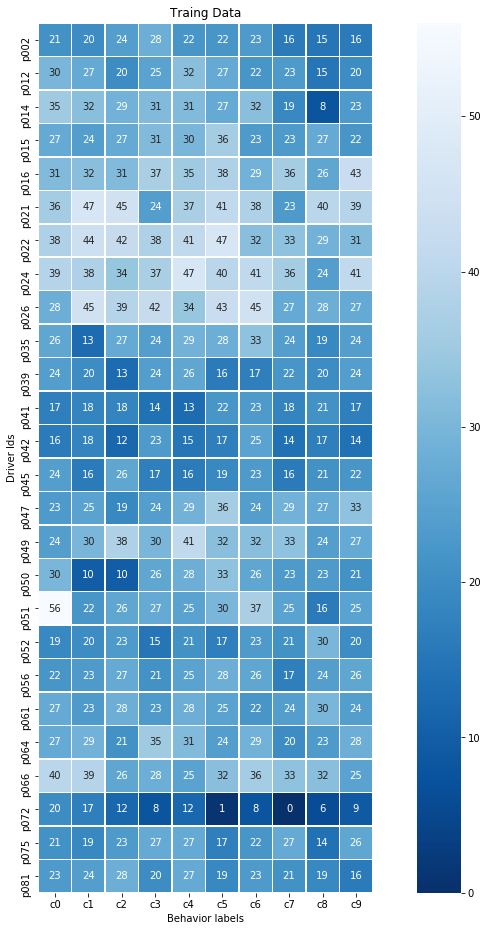

In [7]:
plt.figure(figsize=(16,16))
ax=sns.heatmap(numimgs, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r',xticklabels=labels, yticklabels=driverids);
plt.title('Traing Data')
plt.ylabel('Driver Ids');
plt.xlabel('Behavior labels')

In [8]:
trainImgFileDir='../dataSetImage/stateFarm_distractedDriver_all/imgs/train/'

In [9]:
imgsz2=240*320
imgsz4=120*160
imgsz8=60*80
def cv2GetImgFileDataG2(filename):
    img=cv2.imread(filename, cv2.IMREAD_REDUCED_GRAYSCALE_2)
    img2=np.reshape(img,(1,imgsz2))
    lst=img2.tolist()
    return lst[0]
def cv2GetImgFileDataG4(filename):
    img=cv2.imread(filename, cv2.IMREAD_REDUCED_GRAYSCALE_4)
    img2=np.reshape(img,(1,imgsz4))
    lst=img2.tolist()
    return lst[0]
def cv2GetImgFileDataG8(filename):
    img=cv2.imread(filename, cv2.IMREAD_REDUCED_GRAYSCALE_8)
    img2=np.reshape(img,(1,imgsz8))
    lst=img2.tolist()
    return lst[0]
def cv2GetImgFileDataC2(filename):
    img=cv2.imread(filename, cv2.IMREAD_REDUCED_COLOR_2)
    img2=np.reshape(img,(1,imgsz2))
    lst=img2.tolist()
    return lst[0]
def cv2GetImgFileDataC4(filename):
    img=cv2.imread(filename, cv2.IMREAD_REDUCED_COLOR_4)
    img2=np.reshape(img,(1,imgsz4))
    lst=img2.tolist()
    return lst[0]
def cv2GetImgFileDataC8(filename):
    img=cv2.imread(filename, cv2.IMREAD_REDUCED_COLOR_8)
    img2=np.reshape(img,(1,imgsz8))
    lst=img2.tolist()
    return lst[0]

In [10]:
XTrain2G4=[]
XTrain2G8=[]

In [11]:
for itm in train2:  
    XTrain2G4.append(cv2GetImgFileDataG4(trainImgFileDir+itm[1]+'/'+itm[2]))

In [12]:
print(len(XTrain2G4))
print(len(XTrain2G4[0]))

6728
19200


In [13]:
XTrain2G4NP=np.array(XTrain2G4)

In [40]:
#pcsmdls=['sfdd_g4_n400_pca_0115.pkl','sfdd_g4_n500_pca_0115.pkl','sfdd_g4_n676_pca_0115.pkl','sfdd_g4_n800_pca_0115.pkl']
#dtmdls=['sfdd_g4_n400_dt_0115.pkl','sfdd_g4_n500_pca_0115.pkl','sfdd_g4_n676_pca_0115.pkl','sfdd_g4_n800_pca_0115.pkl','sfdd_g4_org_pca_0115.pkl']
#pca,dt,nb,knn,lr
#400,500,676,800,org
mdllbls=['n400','n500','n676','n800','org']
mdltypes=['dt','nb','knn','lr']
mdltypefullnm={'dt':'Decision Tree','nb':'Naive Bayes','knn':'k-Nearest Neighbor','lr':'Logistic Regression'}
casevrs=[] # case explained variance ratio

In [15]:
pcamdls=[]
for nm in mdllbls[:4]:
    mdl=pickle.load(open('sfdd_g4_'+nm+'_pca_0115.pkl','rb'))
    cumvar=0.0
    for x in mdl.explained_variance_ratio_:
        cumvar+=x
    pcamdls.append(mdl)
    casevrs.append(cumvar)

In [16]:
Ytrain2=[]
for itm in train2:
    Ytrain2.append(int(itm[1][1]))
Ytrain2NP=np.array(Ytrain2)

In [17]:
clsrpts=[]
confmts=[]
scores=[]
casenms=[]
i=0
for nm in mdllbls:
    if nm!='org':
        trainds = pcamdls[i].transform(XTrain2G4NP)
    else:
        trainds = XTrain2G4NP
    for mtp in mdltypes:
        if nm!='org':
            casenms.append('g4_'+nm+'_'+mtp)
            mdl=pickle.load(open('sfdd_g4_'+nm+'_'+mtp+'_0115.pkl','rb'))
            predicted=mdl.predict(trainds)
            scores.append(mdl.score(trainds,Ytrain2NP))
            clsrpts.append(metrics.classification_report(Ytrain2NP, predicted))
            confmts.append(metrics.confusion_matrix(Ytrain2NP, predicted))
    i+=1

In [18]:
trainds = XTrain2G4NP
casenms.append('g4_org_nb')
mdl=pickle.load(open('sfdd_g4_org_nb_0115.pkl','rb'))
predicted=mdl.predict(trainds)
scores.append(mdl.score(trainds,Ytrain2NP))
clsrpts.append(metrics.classification_report(Ytrain2NP, predicted))
confmts.append(metrics.confusion_matrix(Ytrain2NP, predicted))

In [19]:
casenms.append('g4_org_lr')
mdl=pickle.load(open('sfdd_g4_org_lr_0115.pkl','rb'))
predicted=mdl.predict(trainds)
scores.append(mdl.score(trainds,Ytrain2NP))
clsrpts.append(metrics.classification_report(Ytrain2NP, predicted))
confmts.append(metrics.confusion_matrix(Ytrain2NP, predicted))

In [78]:
maxscore=0
maxcasenm=''
for i in range(len(scores)):
    if scores[i]>maxscore:
        maxscore=scores[i]
        maxcasenm=casenms[i]        
    print("(",i,") ",casenms[i]," : ", scores[i])
    #print('---------------------------------------------------------------------')
print("********************************")
print("Max score: ",maxscore,', ',maxcasenm)

( 0 )  g4_n400_dt  :  0.7896848989298454
( 1 )  g4_n400_nb  :  0.8211950059453033
( 2 )  g4_n400_knn  :  0.985731272294887
( 3 )  g4_n400_lr  :  0.9158739595719382
( 4 )  g4_n500_dt  :  0.7893876337693222
( 5 )  g4_n500_nb  :  0.7840368608799049
( 6 )  g4_n500_knn  :  0.986474435196195
( 7 )  g4_n500_lr  :  0.9359393579072532
( 8 )  g4_n676_dt  :  0.7843341260404281
( 9 )  g4_n676_nb  :  0.7138822829964329
( 10 )  g4_n676_knn  :  0.9866230677764566
( 11 )  g4_n676_lr  :  0.9494649227110583
( 12 )  g4_n800_dt  :  0.776307966706302
( 13 )  g4_n800_nb  :  0.6770214030915577
( 14 )  g4_n800_knn  :  0.9866230677764566
( 15 )  g4_n800_lr  :  0.9542211652794292
( 16 )  g4_org_nb  :  0.5301724137931034
( 17 )  g4_org_lr  :  0.990487514863258
********************************
Max score:  0.990487514863258 ,  g4_org_lr


In [49]:
color_sequence = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#c5b0d5',
                  '#8c564b', '#ffbb78', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

('#aec7e8', '#ff7f0e', '#c49c94', '#98df8a', '#ff9896')

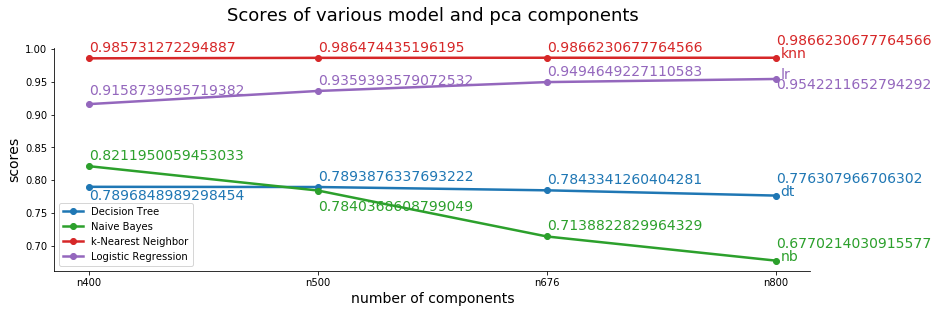

In [131]:
pos_adj={"dt":[-0.02,0.01,0.01,0.02],"nb":[0.01,-0.03,0.01,0.02],"knn":[0.01,0.01,0.01,0.02],"lr":[0.015,0.01,0.01,-0.015]}
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
#fig.subplots_adjust(right=.75, bottom=.02, top=.94)
fig.subplots_adjust(right=1,top=0.9)
for (i,x) in enumerate(mdltypes):
    ylst=[]
    for (j,s) in enumerate(casenms):
        if x in s and 'org' not in s:
            ylst.append(scores[j])
    xlbls=['n400','n500','n676','n800']
    line = plt.plot(xlbls,
                    ylst,
                    lw=2.5,
                    color=color_sequence[i],
                    marker='o',
                    label=mdltypefullnm[x])
    x_pos=3.02
    j=0
    for p, q in zip(xlbls, ylst):
        plt.text(p, q+pos_adj[x][j], str(ylst[j]), color=color_sequence[i], fontsize=14)
        j+=1

    plt.text(x_pos, ylst[3],x, fontsize=14, color=color_sequence[i])
plt.xlabel('number of components',fontsize=14)
plt.ylabel('scores',fontsize=14)
plt.title('Scores of various model and pca components\n', fontsize=18, ha='center')
plt.legend()
plt.show()
fig.savefig('pcamdlsscores.png')

In [ ]:
for i in range(len(scores)):
    print(casenms[i]," : ", scores[i])
    print(clsrpts[i])
    print(confmts[i])
    print('---------------------------------------------------------------------')

In [79]:
# View detail of Logistic Rregression Model Prediction Result (org images)
print("Classification Report and Confusion Matrix of Prediction of Logistric Regress Model based on original Grascale 4 images:")
print(casenms[17]," : ", scores[17])
print(clsrpts[17])
print(confmts[17])

Classification Report and Confusion Matrix of Prediction of Logistric Regress Model based on original Grascale 4 images:
g4_org_lr  :  0.990487514863258
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       724
          1       0.99      0.99      0.99       675
          2       0.98      1.00      0.99       668
          3       1.00      1.00      1.00       679
          4       0.99      0.99      0.99       727
          5       1.00      0.99      0.99       717
          6       0.99      0.99      0.99       714
          7       0.99      0.99      0.99       603
          8       0.99      0.98      0.98       578
          9       0.99      0.98      0.99       643

avg / total       0.99      0.99      0.99      6728

[[715   1   4   0   3   1   0   0   0   0]
 [  1 671   0   0   0   0   0   2   0   1]
 [  1   1 665   0   0   0   1   0   0   0]
 [  0   1   0 677   0   0   0   1   0   0]
 [  0   0   3   2 719   0   2   0   

In [80]:
# Classification Report and Confusion Matrix of of (10) g4_n676_knn
print("Classification Report and Confusion Matrix of Prediction of KNN Model based on 676 components of Grascale 4 images:")
print(casenms[10]," : ", scores[10])
print(clsrpts[10])
print(confmts[10])

Classification Report and Confusion Matrix of Prediction of KNN Model based on 676 components of Grascale 4 images:
g4_n676_knn  :  0.9866230677764566
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       724
          1       0.98      1.00      0.99       675
          2       0.98      0.99      0.98       668
          3       0.98      0.99      0.99       679
          4       0.99      0.98      0.98       727
          5       1.00      0.99      0.99       717
          6       0.99      0.99      0.99       714
          7       1.00      1.00      1.00       603
          8       0.98      0.97      0.98       578
          9       0.98      0.98      0.98       643

avg / total       0.99      0.99      0.99      6728

[[715   1   1   1   4   0   1   0   0   1]
 [  0 672   0   1   0   0   0   0   0   2]
 [  4   2 660   0   0   0   2   0   0   0]
 [  1   0   0 675   3   0   0   0   0   0]
 [  1   1   3   8 710   1   1   0   2 

In [81]:
#XTrain2G4NP
mdl=pickle.load(open('sfdd_g4_org_lr_0115.pkl','rb'))
lrpredicted=mdl.predict(XTrain2G4NP)
#YTrain2NP

In [82]:
trainds = pcamdls[2].transform(XTrain2G4NP)
mdl=pickle.load(open('sfdd_g4_n676_knn_0115.pkl','rb'))
knnn676predicted=mdl.predict(trainds)
#YTrain2NP

In [89]:
#train2
lrmislbls=[]
lrmislbldir={'c0':[],'c1':[],'c2':[],'c3':[],'c4':[],'c5':[],'c6':[],'c7':[],'c8':[],'c9':[]}
for i in range(len(Ytrain2NP)):
    if Ytrain2NP[i]!=lrpredicted[i]:
        tp=train2[i].copy()
        tp.append(lrpredicted[i])
        lrmislbls.append(tp)
        lrmislbldir[train2[i][1]].append([train2[i][2],lrpredicted[i]])
print(len(lrmislbls))
print(lrmislbls[:3])
print(lrmislbldir['c1'])
print(lrmislbldir['c2'])
print(lrmislbldir['c3'])

64
[['p066', 'c6', 'img_6127.jpg', 2], ['p022', 'c4', 'img_72499.jpg', 3], ['p050', 'c9', 'img_99801.jpg', 8]]
[['img_77183.jpg', 9], ['img_34132.jpg', 7], ['img_96569.jpg', 7], ['img_99452.jpg', 0]]
[['img_25681.jpg', 6], ['img_19357.jpg', 1], ['img_18257.jpg', 0]]
[['img_59937.jpg', 1], ['img_26377.jpg', 7]]


In [90]:
fif=open('sfdd_lr_mislabled_0115.csv','w')
for x in train2:
    fif.write(','.join(x)+'\n')
fif.close() 

In [105]:
img_path='../dataSetImage/stateFarm_distractedDriver_all/imgs/train/'
img10 = cv2.imread(img_path+'c1/'+lrmislbldir['c1'][0][0], cv2.IMREAD_COLOR) #(120,160)
img20 = cv2.imread(img_path+'c1/'+lrmislbldir['c1'][1][0], cv2.IMREAD_COLOR)
img30 = cv2.imread(img_path+'c1/'+lrmislbldir['c1'][2][0], cv2.IMREAD_COLOR)
img40 = cv2.imread(img_path+'c1/'+lrmislbldir['c1'][3][0], cv2.IMREAD_COLOR)
img10 = cv2.cvtColor(img10, cv2.COLOR_RGB2BGR)
img20 = cv2.cvtColor(img20, cv2.COLOR_RGB2BGR)
img30 = cv2.cvtColor(img30, cv2.COLOR_RGB2BGR)
img40 = cv2.cvtColor(img40, cv2.COLOR_RGB2BGR)
img1 = cv2.imread(img_path+'c1/'+lrmislbldir['c1'][0][0], cv2.IMREAD_REDUCED_GRAYSCALE_4) #(120,160)
img2 = cv2.imread(img_path+'c1/'+lrmislbldir['c1'][1][0], cv2.IMREAD_REDUCED_GRAYSCALE_4)
img3 = cv2.imread(img_path+'c1/'+lrmislbldir['c1'][2][0], cv2.IMREAD_REDUCED_GRAYSCALE_4)
img4 = cv2.imread(img_path+'c1/'+lrmislbldir['c1'][3][0], cv2.IMREAD_REDUCED_GRAYSCALE_4)

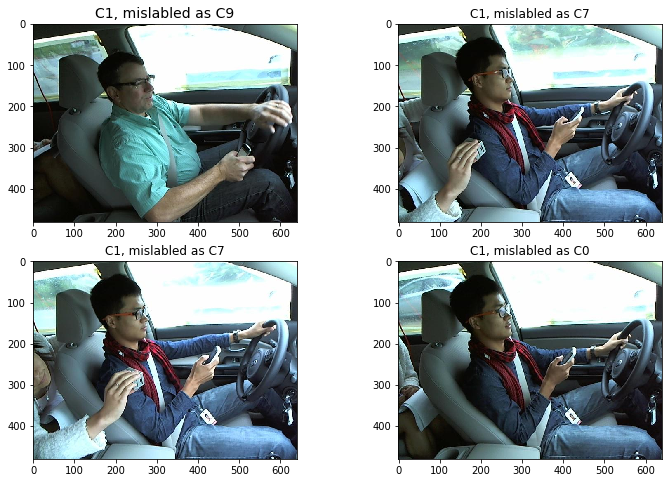

In [123]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title('C1, mislabled as C'+str(lrmislbldir['c1'][0][1]),fontsize=14, ha='center')
plt.imshow(img10)
plt.subplot(222)
plt.title('C1, mislabled as C'+str(lrmislbldir['c1'][1][1]))
plt.imshow(img20)
plt.subplot(223)
plt.title('C1, mislabled as C'+str(lrmislbldir['c1'][2][1]))
plt.imshow(img30)
plt.subplot(224)
plt.title('C1, mislabled as C'+str(lrmislbldir['c1'][3][1]))
plt.imshow(img40)

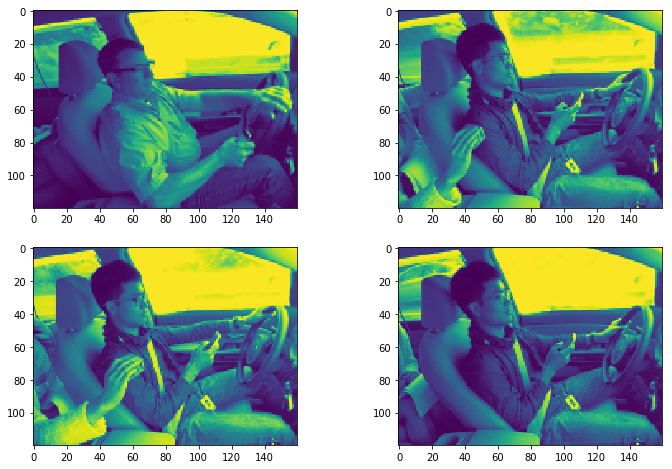

In [122]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(img1)
plt.subplot(222)
plt.imshow(img2)
plt.subplot(223)
plt.imshow(img3)
plt.subplot(224)
plt.imshow(img4)

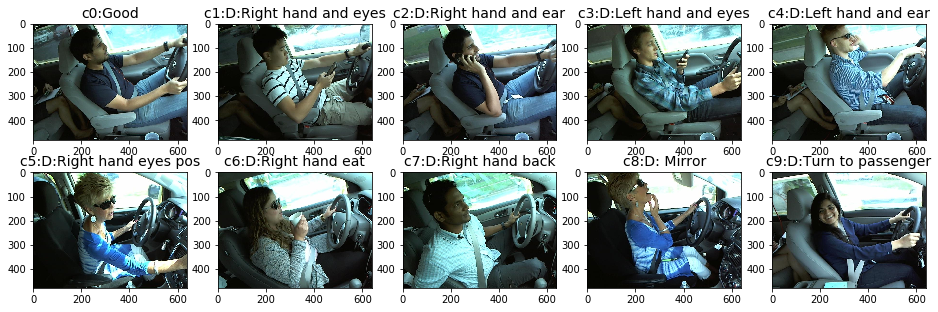

In [128]:
#show cases
img_path='../dataSetImage/stateFarm_distractedDriver_all/imgs/train/'
pickedimgs={'c0':'img_1928.jpg','c1':'img_1916.jpg','c2':'img_1521.jpg','c3':'img_392.jpg','c4':'img_4250.jpg','c5':'img_2645.jpg','c6':'img_397.jpg','c7':'img_3382.jpg','c8':'img_2409.jpg','c9':'img_2051.jpg'}
lbldesc={'c0':'Good','c1':'D:Right hand and eyes','c2':'D:Right hand and ear','c3':'D:Left hand and eyes','c4':'D:Left hand and ear','c5':'D:Right hand eyes pos','c6':'D:Right hand eat','c7':'D:Right hand back','c8':'D: Mirror','c9':'D:Turn to passenger'}
fig=plt.figure(figsize=(16,5))
i=1
for lbl in pickedimgs:
    plt.subplot(2,5,i)
    plt.title(lbl+":"+lbldesc[lbl],fontsize=14, ha='center')
    img = cv2.imread(img_path+lbl+'/'+pickedimgs[lbl], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    i+=1
fig.savefig("showcases.jpg")